<a href="https://colab.research.google.com/github/kirath2205/Final-Year-Project/blob/main/Autoencoder_cifar_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
!pip install sklearn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import tensorflow as tf
import keras
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, MaxPool2D, Flatten, BatchNormalization
from keras.layers import Conv1D, MaxPool1D, Reshape
from keras.layers import Input, Dense, Dropout, Activation, Add, Concatenate
from keras.datasets import cifar10
from keras import regularizers
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adadelta
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
#from keras.objectives import mean_squared_error

from sklearn.utils import class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, RobustScaler, StandardScaler


In [36]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [37]:
'''x_test_extra = []
y_test_extra = []
x_train_final = []
y_train_final = []
count = [0, 0, 0]
for i, j in zip(x_train, y_train):
    if (j==2):
        if(count[0]<2000):
            x_test_extra.append(i)
            y_test_extra.append(j)
            count[0]+=1
        else:
            x_train_final.append(i)
            y_train_final.append(j)
    elif (j==4):
        if(count[1]<2000):
            x_test_extra.append(i)
            y_test_extra.append(j)
            count[1]+=1
        else:
            x_train_final.append(i)
            y_train_final.append(j)
    elif (j==9):
        if(count[2]<2000):
            x_test_extra.append(i)
            y_test_extra.append(j)
            count[2]+=1
        else:
            x_train_final.append(i)
            y_train_final.append(j)
    else:
        x_train_final.append(i)
        y_train_final.append(j)
        
x_test_extra = np.array(x_test_extra)
y_test_extra = np.array(y_test_extra)
x_train_final = np.array(x_train_final)
y_train_final = np.array(y_train_final)'''

'x_test_extra = []\ny_test_extra = []\nx_train_final = []\ny_train_final = []\ncount = [0, 0, 0]\nfor i, j in zip(x_train, y_train):\n    if (j==2):\n        if(count[0]<2000):\n            x_test_extra.append(i)\n            y_test_extra.append(j)\n            count[0]+=1\n        else:\n            x_train_final.append(i)\n            y_train_final.append(j)\n    elif (j==4):\n        if(count[1]<2000):\n            x_test_extra.append(i)\n            y_test_extra.append(j)\n            count[1]+=1\n        else:\n            x_train_final.append(i)\n            y_train_final.append(j)\n    elif (j==9):\n        if(count[2]<2000):\n            x_test_extra.append(i)\n            y_test_extra.append(j)\n            count[2]+=1\n        else:\n            x_train_final.append(i)\n            y_train_final.append(j)\n    else:\n        x_train_final.append(i)\n        y_train_final.append(j)\n        \nx_test_extra = np.array(x_test_extra)\ny_test_extra = np.array(y_test_extra)\nx_train

In [38]:
'''x_test_final = np.append(x_test_extra, x_test, axis=0)
y_test_final = np.append(y_test_extra, y_test, axis=0)'''

'x_test_final = np.append(x_test_extra, x_test, axis=0)\ny_test_final = np.append(y_test_extra, y_test, axis=0)'

In [39]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255

In [40]:
#from sklearn.model_selection import train_test_split

# Split the data
#x_train, x_valid, y_trainf, y_validf = train_test_split(x_train_final, y_train_final, test_size=0.2, random_state=42, shuffle= True)

In [41]:
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)
#y_test_one_hot = np_utils.to_categorical(y_test_final, 10)

In [42]:
def create_block(input, chs): ## Convolution block of 2 layers
    x = input
    for i in range(2):
        x = Conv2D(chs, 3, padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
    return x


In [43]:
def unet():  ## I commented several layers of the model for descreasing model complexity as the results were almost same
    input = Input((32,32,3))
    
    # Encoder
    block1 = create_block(input, 16)
    x = MaxPool2D(2)(block1)
    block2 = create_block(x, 32)
    
    # Middle
    x = MaxPool2D(2)(block2)
    middle = create_block(x, 64)
    
    x = Conv2DTranspose(32, kernel_size=2, strides=2)(middle)
    x = Concatenate()([block2, x])
    x = create_block(x, 32)
    x = Conv2DTranspose(16, kernel_size=2, strides=2)(x)
    x = Concatenate()([block1, x])
    x = create_block(x, 16)
    
    # output
    x = Conv2D(3, 1)(x)
    output = Activation("sigmoid")(x)
    
    return Model(input, middle), Model(input, output)

In [44]:
def general_ae():
    input = Input((32,32,3))
    
    # Encoder
    block1 = create_block(input, 32)
    x = MaxPool2D(2)(block1)
    block2 = create_block(x, 64)
    
    #Middle
    x = MaxPool2D(2)(block2)
    middle = create_block(x, 128)
    
    # Decoder
    block3 = create_block(middle, 64)
    up1 = UpSampling2D((2,2))(block3)
    block4 = create_block(up1, 32)
    up2 = UpSampling2D((2,2))(block4)
    
    # output
    x = Conv2D(3, 1)(up2)
    output = Activation("sigmoid")(x)
    return Model(input, middle), Model(input, output)

In [45]:
def run_ae(m):  ## function for choosing unet/general autoencoder
    if m=='unet':
        encoder, model = unet()
    elif m=='ae':
        encoder, model = general_ae()
        
    return encoder, model

In [46]:
def loss_function(y_true, y_pred):  ## loss function for using in autoencoder models
    mses = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    return K.sum(mses, axis=(1,2))

In [47]:
encoder_unet, model_unet = run_ae('unet')
model_unet.compile(SGD(1e-3, 0.9), loss=loss_function)

In [48]:
model_path = 'Desktop/Autoencoder_models/unet_cifar_10.h5'
er = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_delta=0.0001)
ch = tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True),
callbacks = [er, lr , ch]
history = model_unet.fit(x_train, x_train, 
                         batch_size=512,
                         epochs=100,
                         verbose=1,
                         validation_data=(x_test, x_test),
                         shuffle=True, callbacks=callbacks)

Epoch 1/100
97/98 [============================>.] - ETA: 0s - loss: 7.9545
Epoch 00001: val_loss improved from inf to 53.39440, saving model to Desktop/Autoencoder_models/unet_cifar_10.h5
98/98 [==============================] - 3s 32ms/step - loss: 7.9227 - val_loss: 53.3944 - lr: 0.0010
Epoch 2/100
97/98 [============================>.] - ETA: 0s - loss: 2.6797
Epoch 00002: val_loss improved from 53.39440 to 9.98201, saving model to Desktop/Autoencoder_models/unet_cifar_10.h5
98/98 [==============================] - 3s 30ms/step - loss: 2.6793 - val_loss: 9.9820 - lr: 0.0010
Epoch 3/100
97/98 [============================>.] - ETA: 0s - loss: 2.0394
Epoch 00003: val_loss improved from 9.98201 to 6.74832, saving model to Desktop/Autoencoder_models/unet_cifar_10.h5
98/98 [==============================] - 3s 30ms/step - loss: 2.0384 - val_loss: 6.7483 - lr: 0.0010
Epoch 4/100
97/98 [============================>.] - ETA: 0s - loss: 1.7240
Epoch 00004: val_loss improved from 6.74832 to

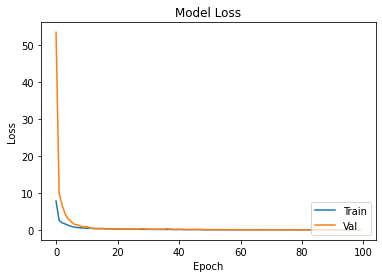

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()
